In [112]:
import pandas as pd
from transformers import ViTModel, ViTImageProcessor
import torch
from PIL import Image
import numpy as np

In [113]:
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [114]:
import torch
from PIL import Image

def get_vit_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt")

        with torch.no_grad():
            outputs = model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        
        if embedding.shape[0] == 0:  # Check if embedding is empty
            print(f"⚠️ Warning: Empty embedding for {image_path}")

        return embedding
    except Exception as e:
        print(f"❌ Error processing {image_path}: {e}")
        return None


In [115]:
import faiss

# Create FAISS index (L2 similarity search)
dimension = 768  # ViT embedding size
index = faiss.IndexFlatL2(dimension)

# Load and store logo embeddings
import os

# Path to your logo directory
logo_dir = "resized_favicons"

# Get all image file paths in the directory
logo_paths = [os.path.join(logo_dir, f) for f in os.listdir(logo_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
logo_embeddings = []
for logo_path in logo_paths:
    embedding = get_vit_embedding(logo_path)
    logo_embeddings.append(embedding)
    print(len(logo_embeddings))

logo_embeddings = np.array(logo_embeddings).astype('float32')  # Ensure correct type

# Create FAISS index
d = logo_embeddings.shape[1]  # Dimension (should be 768 for ViT-Base)
index = faiss.IndexFlatL2(d)  # L2 distance (euclidean)

# Add embeddings to FAISS index
faiss.normalize_L2(logo_embeddings)  # Normalize all embeddings
index.add(logo_embeddings)  # Add normalized embeddings


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
def find_similar_logos(query_logo_path, similarity_threshold):  
    query_embedding = get_vit_embedding(query_logo_path).reshape(1, -1).astype('float32')
    
    query_embedding = get_vit_embedding(query_logo_path).reshape(1, -1).astype('float32')
    faiss.normalize_L2(query_embedding)  # Normalize query embedding
    distances, indices = index.search(query_embedding, len(logo_paths))    
    similar_logos = []
    for dist, idx in zip(distances[0], indices[0]):
        if dist <= similarity_threshold:  # Adjust threshold for cosine similarity
            similar_logos.app   end(logo_paths[idx])
    
    return similar_logos

In [109]:
import os
import cv2
import shutil

# Define directories
old_dir = "old_favicons"
new_dir = "resized_favicons"

# Ensure the destination directory exists
os.makedirs(new_dir, exist_ok=True)

# Process all images in old_favicons
for filename in os.listdir(old_dir):
    if filename.endswith((".png", ".jpg", ".jpeg")):  # Filter image files
        old_path = os.path.join(old_dir, filename)
        new_path = os.path.join(new_dir, filename)

        # Read and resize the image
        image = cv2.imread(old_path)
        if image is None:
            print(f"Skipping {filename}, could not read.")
            continue
        
        resized_image = cv2.resize(image, (128, 128))  # Resize to 128x128

        # Save the resized image
        cv2.imwrite(new_path, resized_image)

print("✅ All images copied and resized to 128x128 in 'resized_favicons/'.")


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


✅ All images copied and resized to 128x128 in 'resized_favicons/'.


libpng warning: iCCP: known incorrect sRGB profile


In [63]:
import os
import shutil

# Directory where grouped logos will be stored
output_dir = "similar_groups"
os.makedirs(output_dir, exist_ok=True)
print("Directory was made")

# Keep track of already assigned logos
processed_logos = set()
group_count = 1  # Group numbering

for logo_path in logo_paths:
    if logo_path in processed_logos:
        continue  # Skip if already assigned to a group

    # Find similar logos
    similar_logos = find_similar_logos(logo_path, similarity_threshold=0.6)

    # Create a new directory for the group
    group_dir = os.path.join(output_dir, f"group_{group_count}")
    os.makedirs(group_dir, exist_ok=True)

    # Move similar logos to the group folder
    for similar_logo in similar_logos:
        if similar_logo not in processed_logos:  # Avoid duplicates
            shutil.copy(similar_logo, os.path.join(group_dir, os.path.basename(similar_logo)))
            processed_logos.add(similar_logo)

    group_count += 1  # Increment group number

print(f"Logos grouped into {group_count - 1} directories in '{output_dir}'")


Directory was made
Logos grouped into 509 directories in 'similar_groups'


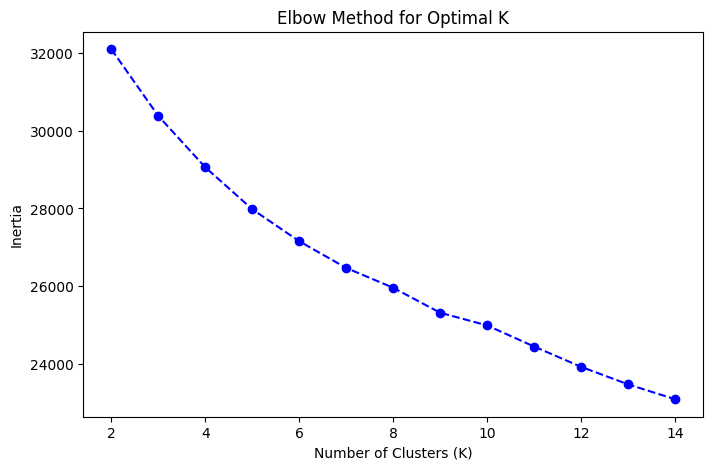

Clustering completed. Logos organized into 50 clusters.


/tmp/ipykernel_68656/3470631419.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(num_clusters), y=cluster_counts, palette="viridis")


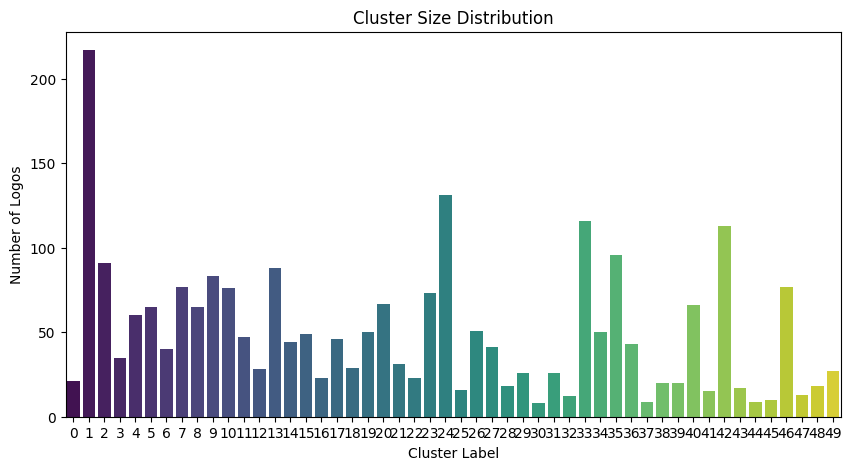

Silhouette Score: 0.3012 (Higher = Better)


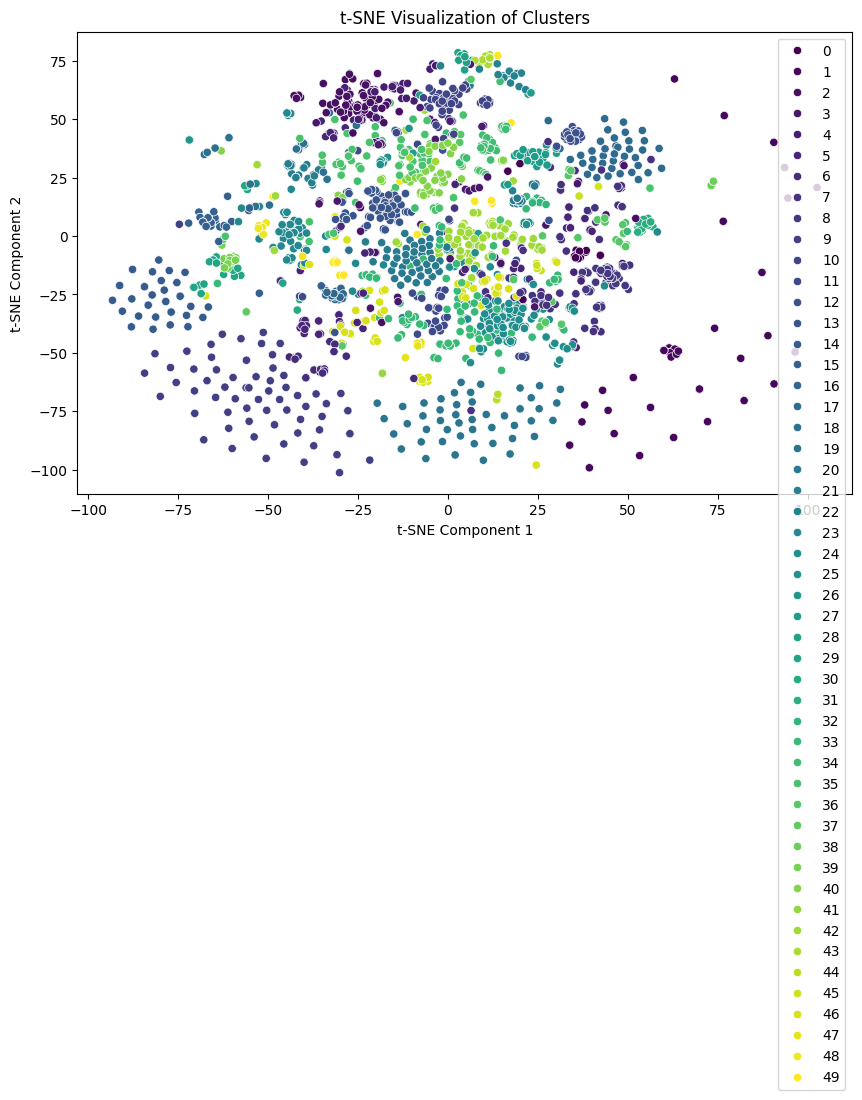

In [129]:
import os
import random
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from PIL import Image

# Parameters
num_clusters = 50  # Adjust if needed
output_folder = "clustered_favicons"
plot_folder = "plots"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(plot_folder, exist_ok=True)

# Ensure embeddings are in correct shape
logo_embeddings = np.array(logo_embeddings).astype('float32')
if logo_embeddings.ndim == 1:
    logo_embeddings = logo_embeddings.reshape(1, -1)

### **1. Elbow Method to Find Optimal K**
inertia_values = []
k_values = range(2, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(logo_embeddings)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.savefig(os.path.join(plot_folder, "elbow_method.png"))  # Save the plot
plt.show(block=True)
plt.close()

### **2. Apply K-Means Clustering**
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(logo_embeddings)

# Create directories for each cluster
cluster_dirs = {i: os.path.join(output_folder, f"cluster_{i}") for i in range(num_clusters)}
for path in cluster_dirs.values():
    os.makedirs(path, exist_ok=True)

# Move images into respective cluster directories
for img_path, cluster in zip(logo_paths, cluster_labels):
    shutil.copy(img_path, os.path.join(cluster_dirs[cluster], os.path.basename(img_path)))

print(f"Clustering completed. Logos organized into {num_clusters} clusters.")

### **3. Cluster Size Distribution**
cluster_counts = np.bincount(cluster_labels)
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(num_clusters), y=cluster_counts, palette="viridis")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Logos")
plt.title("Cluster Size Distribution")
plt.savefig(os.path.join(plot_folder, "cluster_size_distribution.png"))  # Save the plot
plt.show(block=True)
plt.close()

### **4. Compute Silhouette Score**
sil_score = silhouette_score(logo_embeddings, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f} (Higher = Better)")

# Save Silhouette Score to a text file
with open(os.path.join(plot_folder, "silhouette_score.txt"), "w") as f:
    f.write(f"Silhouette Score: {sil_score:.4f}\n")

### **5. t-SNE Visualization (Reduce Dim to 2D)**
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
logo_embeddings_2d = tsne.fit_transform(logo_embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=logo_embeddings_2d[:, 0], y=logo_embeddings_2d[:, 1], hue=cluster_labels, palette="viridis", legend="full")
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.savefig(os.path.join(plot_folder, "tsne_clusters.png"))  # Save the plot
plt.show(block=True)
plt.close()
